In [13]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score, adjusted_rand_score, log_loss
from sklearn.datasets import make_classification
%config IPCompleter.greedy=True
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LassoCV, RidgeCV, LinearRegression
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn import metrics
import scipy
sns.set_style("whitegrid")
# sns.set(rc={'figure.figsize': (12, 6)})
%config InlineBackend.figure_format = 'svg'
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 17

In [14]:
train = pd.read_csv("../files/titanic/train.csv")
test = pd.read_csv("../files/titanic/test.csv")

In [15]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:xlabel='Pclass', ylabel='count'>

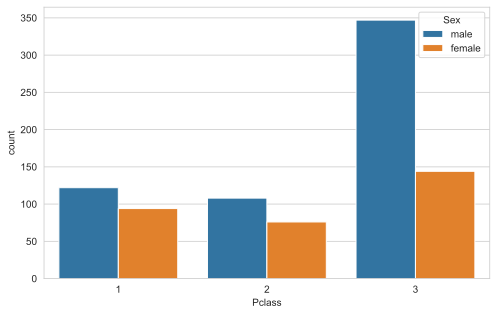

In [16]:
sns.countplot(train["Pclass"], hue=train["Sex"])

Percentage of CabinBool = 1 who survived: 66.66666666666666
Percentage of CabinBool = 0 who survived: 29.985443959243085


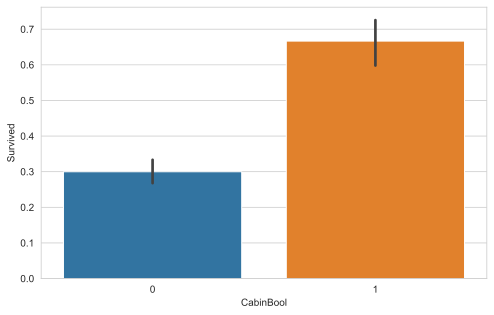

In [17]:
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

#calculate percentages of CabinBool vs. survived
print("Percentage of CabinBool = 1 who survived:", train["Survived"][train["CabinBool"] == 1].value_counts(normalize = True)[1]*100)

print("Percentage of CabinBool = 0 who survived:", train["Survived"][train["CabinBool"] == 0].value_counts(normalize = True)[1]*100)
#draw a bar plot of CabinBool vs. survival
sns.barplot(x="CabinBool", y="Survived", data=train)
plt.show()

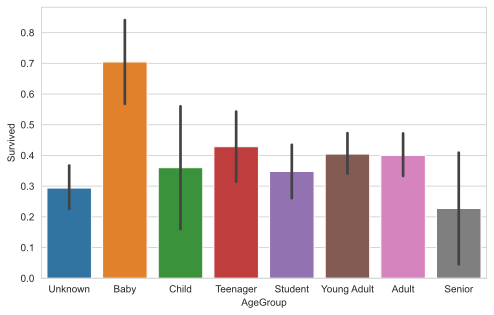

In [18]:
#sort the ages into logical categories
train["Age"] = train["Age"].fillna(-0.5)
test["Age"] = test["Age"].fillna(-0.5)
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

#draw a bar plot of Age vs. survival
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show()

In [19]:
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

In [20]:
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

In [21]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,CabinBool,AgeGroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,Young Adult


In [22]:
#create a combined group of both datasets
combine = [train, test]

#extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [23]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


In [24]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,CabinBool,AgeGroup,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0,Student,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1,Adult,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0,Young Adult,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1,Young Adult,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0,Young Adult,1


In [25]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,CabinBool,AgeGroup,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,0,Young Adult,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,0,Adult,3
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,0,Senior,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,0,Young Adult,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,0,Student,3
